In [15]:
# імпортуємо необхідні бібліотеки
import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow.keras.applications.inception_v1 import InceptionV1
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image


In [4]:
# завантажуємо датасет fashion-mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_train.shape, x_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [6]:
x_train = np.array([np.array(Image.fromarray(img).resize((75,75), resample=Image.BILINEAR)) for img in x_train])
x_test = np.array([np.array(Image.fromarray(img).resize((75,75), resample=Image.BILINEAR)) for img in x_test])

x_train.shape, x_test.shape

((60000, 75, 75, 3), (10000, 75, 75, 3))

In [17]:
# завантажуємо попередньо натреновану модель Inception-v1
# module_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"
# base_model = hub.KerasLayer(module_url, weights='imagenet', input_shape=(75, 75, 3), trainable=False)

m = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/4")])     # load the tensorflow hub model
m.build([None, 75, 75, 3])
m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [18]:
# # завантажуємо попередньо натреновану модель Inception-v3
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model = m

from tensorflow import keras

x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(256, activation='relu')(x)
predictions = keras.layers.Dense(10, activation='softmax')(x)


model = keras.models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:

y = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

# Evaluate the model on the test set
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
     

Epoch 1/3
1875/1875 [==============================] - 34s 11ms/step - loss: 2.2915 - accuracy: 0.6501 - val_loss: 0.8213 - val_accuracy: 0.7025
Epoch 2/3
1875/1875 [==============================] - 20s 10ms/step - loss: 0.7312 - accuracy: 0.7271 - val_loss: 0.7205 - val_accuracy: 0.7138
Epoch 3/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.6971 - accuracy: 0.7409 - val_loss: 0.6941 - val_accuracy: 0.7394
Test loss: 0.6940925717353821
Test accuracy: 0.7394000291824341


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4_input (InputL  [(None, 75, 75, 3)]      0         
 ayer)                                                           
                                                                 
 keras_layer_4 (KerasLayer)  (None, 1001)              6633209   
                                                                 
 flatten_2 (Flatten)         (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 256)               256512    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 6,892,291
Trainable params: 259,082
Non-trainable params: 6,633,209
_____________________________________________

In [22]:
from keras.layers import concatenate
import tensorflow as tf

img_a_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = tf.keras.layers.Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = tf.keras.layers.Dense(16, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='linear')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 16)           336         ['merge_features[1][0

In [23]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [24]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [25]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

1/1 [==============================] - 0s 195ms/step


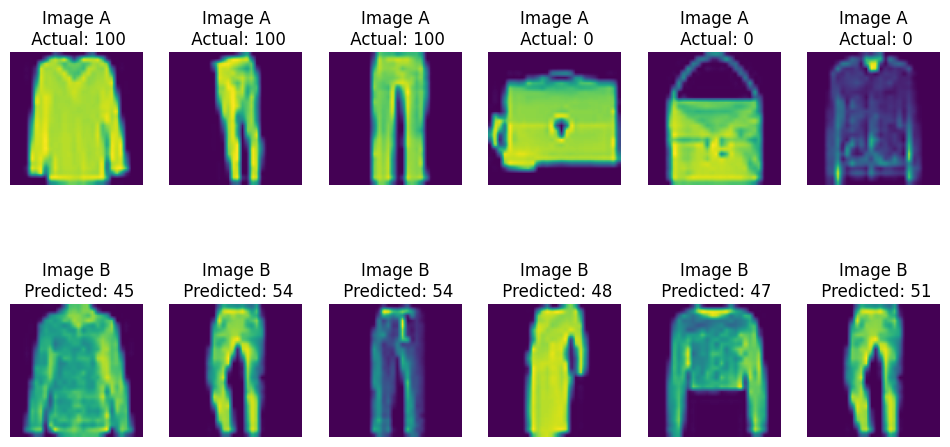

In [26]:
import matplotlib.pyplot as plt
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [27]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 4,
    verbose = True)

1/1 [==============================] - 0s 23ms/step
Epoch 1/4
500/500 [==============================] - 85s 166ms/step - loss: 0.5094 - mae: 0.3709 - val_loss: 0.3848 - val_mae: 0.2776
Epoch 2/4
500/500 [==============================] - 89s 179ms/step - loss: 0.3577 - mae: 0.2441 - val_loss: 0.3222 - val_mae: 0.2118
Epoch 3/4
500/500 [==============================] - 98s 196ms/step - loss: 0.3367 - mae: 0.2182 - val_loss: 0.3119 - val_mae: 0.1946
Epoch 4/4
500/500 [==============================] - 102s 204ms/step - loss: 0.3105 - mae: 0.1953 - val_loss: 0.3067 - val_mae: 0.1894


1/1 [==============================] - 0s 19ms/step


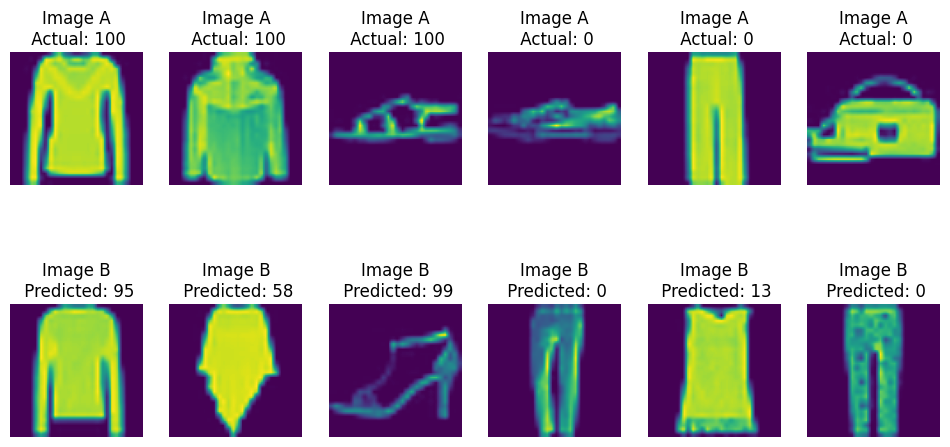

In [28]:
_ = show_model_output()

In [29]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 3s 21ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 0.493s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.128639
[t-SNE] KL divergence aft

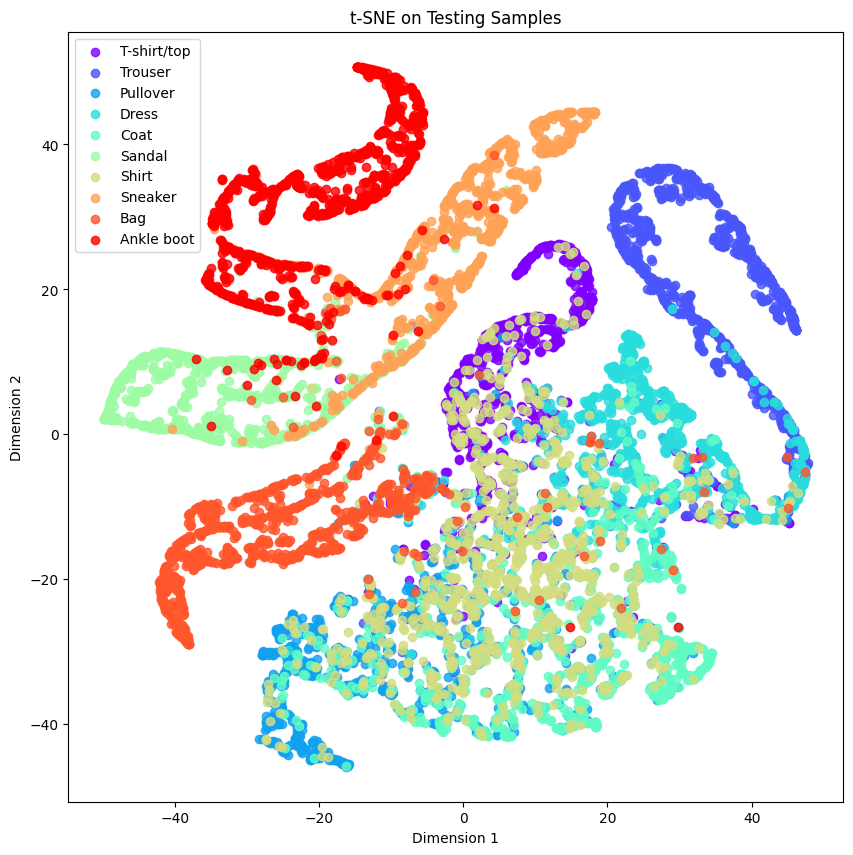

In [30]:
obj_categories = [  
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)